Usando dispositivo: cuda
Backbone cargado y movido a GPU.
Dataset completo cargado desde: /lustre/proyectos/p032/datasets/images/3kvasir
Total de imágenes encontradas: 1500
Clases (carpetas) encontradas: ['normal-cecum', 'normal-pylorus', 'normal-z-line']
Dividiendo dataset (estratificado): 1050 (Train), 149 (Val), 301 (Test)
DataLoaders creados. Tamaño train: 1050, val: 149
Iniciando entrenamiento de la cabeza lineal (Linear Probing)...


/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/20 - Train Loss: 0.8366 - Val Loss: 0.9519 - Val Acc: 51.01%
Epoch 2/20 - Train Loss: 0.6155 - Val Loss: 0.6098 - Val Acc: 79.87%
Epoch 3/20 - Train Loss: 0.4956 - Val Loss: 0.5133 - Val Acc: 80.54%
Epoch 4/20 - Train Loss: 0.4495 - Val Loss: 0.4540 - Val Acc: 84.56%
Epoch 5/20 - Train Loss: 0.4028 - Val Loss: 0.4384 - Val Acc: 84.56%
Epoch 6/20 - Train Loss: 0.3701 - Val Loss: 0.4242 - Val Acc: 83.89%
Epoch 7/20 - Train Loss: 0.3657 - Val Loss: 0.3764 - Val Acc: 87.25%
Epoch 8/20 - Train Loss: 0.3364 - Val Loss: 0.3680 - Val Acc: 84.56%
Epoch 9/20 - Train Loss: 0.3274 - Val Loss: 0.3405 - Val Acc: 86.58%
Epoch 10/20 - Train Loss: 0.3368 - Val Loss: 0.3672 - Val Acc: 86.58%
Epoch 11/20 - Train Loss: 0.3170 - Val Loss: 0.3346 - Val Acc: 87.25%
Epoch 12/20 - Train Loss: 0.3125 - Val Loss: 0.3317 - Val Acc: 87.25%
Epoch 13/20 - Train Loss: 0.2833 - Val Loss: 0.3166 - Val Acc: 89.26%
Epoch 14/20 - Train Loss: 0.2860 - Val Loss: 0.3057 - Val Acc: 87.92%
Epoch 15/20 - Train Loss: 0.2

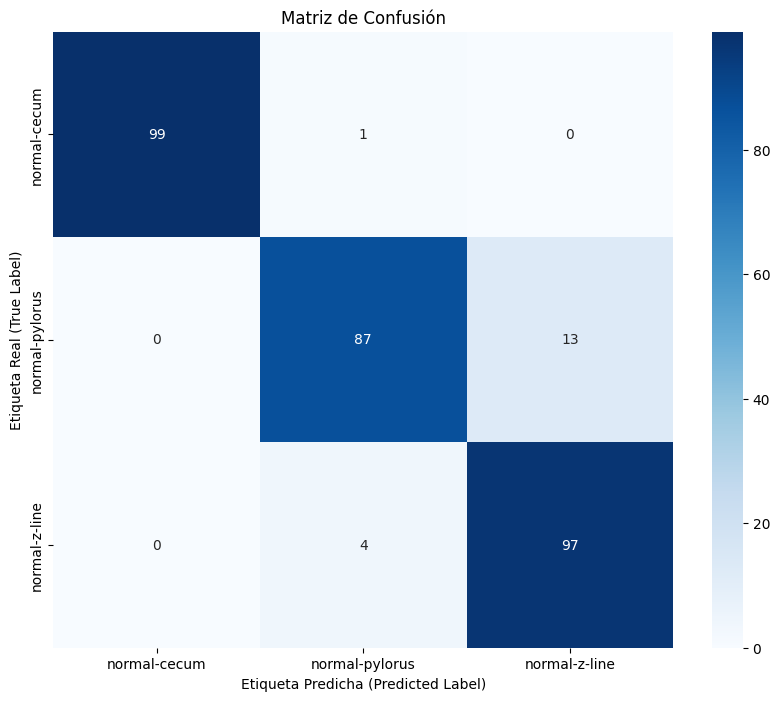

In [17]:
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
# CAMBIADO: random_split ya no se usa, importamos Subset
from torch.utils.data import DataLoader, Dataset, Subset
from collections import OrderedDict
import numpy as np
# AÑADIDO: ImageFolder es la herramienta estándar para tu estructura de dataset
from torchvision.datasets import ImageFolder
# --- AÑADIDO: Importar las bibliotecas de ploteo al inicio ---
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# --- AÑADIDO: Importar train_test_split para estratificación ---
from sklearn.model_selection import train_test_split

# --- 1. CONFIGURACIÓN INICIAL ---
# ==========================================================
# Coloca aquí la ruta a tu modelo .pth (el checkpoint de Lightning)
PATH_MODELO_SSL = "/lustre/proyectos/p032/models/multi_pretext_model2.ckpt"
MODEL_PATH = "/lustre/home/opacheco/MEDA_Challenge/models/221025MG_backbone.ssl.pth"

# CAMBIADO: Apunta al directorio raíz que contiene las 3 carpetas de clases
DATASET='/lustre/proyectos/p032/datasets/images/3kvasir' # Opcional, solo para referencia
PATH_DATASET = "/lustre/proyectos/p032/datasets/images/3kvasir" # <-- ¡CAMBIO IMPORTANTE!

# CAMBIADO: Actualizado a 3 clases según tu descripción
NUM_CLASES = 3

# Parámetros
BATCH_SIZE = 64
EPOCHS_DE_PRUEBA = 20
LEARNING_RATE = 0.001
JIGSAW_N = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# AÑADIDO: Semilla para reproducibilidad en la división
SEED = 42

print(f"Usando dispositivo: {DEVICE}")
# --- 4. Modelo Multi-Pretexto (Versión LightningModule) ---
# ... (El código del modelo es idéntico) ...
class MultiPretextSSL_Lightning(pl.LightningModule):
    def __init__(self, backbone, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters('learning_rate') # Guarda lr
        self.backbone = backbone
        self.lr = learning_rate
        
        num_features = 512 # Salida de ResNet18
        
        # --- DECODER CORREGIDO PARA 28x28 ---
        decoder_layers_28x28 = [
            nn.ConvTranspose2d(num_features, 256, kernel_size=4, stride=1, padding=0), # 1x1 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1), # 4x4 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),    # 14x14 -> 28x28
            nn.Sigmoid()
        ]
        
        self.color_head = nn.Sequential(*decoder_layers_28x28)
        self.patch_head = nn.Sequential(*decoder_layers_28x28)
        
        # --- JIGSAW HEAD CORREGIDO PARA N=4 (16 patches) ---
        self.n_patches = JIGSAW_N * JIGSAW_N # 16
        self.jigsaw_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, self.n_patches * self.n_patches) # 16*16 = 256
        )

    def forward(self, x, task="color"):
        feats = self.backbone(x)
        if task == "color":
            return self.color_head(feats)
        elif task == "patch":
            return self.patch_head(feats)
        elif task == "jigsaw":
            return self.jigsaw_head(feats)

    def training_step(self, batch, batch_idx):
        # (El código es idéntico)
        imgs = batch
        task = random.choice(["color", "patch", "jigsaw"])
        # ... (lógica de loss) ...
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

class MoCoLightning(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.encoder_q = nn.Sequential(backbone)

resnet = models.resnet18(weights=None) 
# Tu backbone (quitando la capa FC final)
backbone_structure = nn.Sequential(*list(resnet.children())[:-1])

# Cargar el estado
encoder_wrapper = MoCoLightning(backbone=backbone_structure)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

# Cargar los pesos en la estructura
encoder_wrapper.encoder_q[0].load_state_dict(state_dict)

# --- Este es tu backbone listo para usar ---
ssl_backbone = encoder_wrapper.encoder_q[0].to(DEVICE)
print("Backbone cargado y movido a GPU.")
model = MultiPretextSSL_Lightning.load_from_checkpoint(PATH_MODELO_SSL, backbone=ssl_backbone)

# Congelar todo el backbone
for param in model.backbone.parameters():
    param.requires_grad = False

in_features = 512  # ResNet18 sin FC tiene 512 features
# Crear la cabeza lineal
# --- CAMBIADO: Asegurarse de que NUM_CLASES se actualice si es necesario ---
# (La lógica de actualización ya está abajo, pero la cabeza lineal debe
# crearse DESPUÉS de conocer el NUM_CLASES real)
# linear_head = nn.Linear(in_features, NUM_CLASES) # Movido más abajo


# --- 5. DEFINIR TRANSFORMACIONES Y CARGAR/DIVIDIR DATASET ---

data_transform = transforms.Compose([
    transforms.Resize(224),               # redimensiona la imagen
    transforms.CenterCrop(224),           # recorta el centro
    transforms.ToTensor(),                # convierte a tensor [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # normalización ImageNet
                         std=[0.229, 0.224, 0.225])
])

# --- 6. CREAR DATASETS Y DATALOADERS (LÓGICA NUEVA) ---

try:
    full_dataset = ImageFolder(PATH_DATASET, transform=data_transform)
    print(f"Dataset completo cargado desde: {PATH_DATASET}")
    print(f"Total de imágenes encontradas: {len(full_dataset)}")
    print(f"Clases (carpetas) encontradas: {full_dataset.classes}")
    
    if len(full_dataset.classes) != NUM_CLASES:
        print(f"¡Advertencia! Se esperaban {NUM_CLASES} clases pero se encontraron {len(full_dataset.classes)} carpetas.")
        NUM_CLASES = len(full_dataset.classes)
        print(f"NUM_CLASES actualizado a {NUM_CLASES}")

except FileNotFoundError:
    print(f"Error: No se encontró el directorio {PATH_DATASET}")
    print("Asegúrate de que 'PATH_DATASET' apunte al directorio que contiene las carpetas de tus clases.")
    raise

# --- CAMBIADO: Lógica de random_split reemplazada por train_test_split (estratificado) ---

# 1. Definir proporciones (tus proporciones: 30% train, 10% val, 60% test)
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1
TEST_RATIO = 1.0 - TRAIN_RATIO - VAL_RATIO # 0.6

# 2. Obtener etiquetas para estratificación
targets = full_dataset.targets
indices = list(range(len(targets)))

# 3. Primera división (Train vs. Val+Test)
# Dividimos para obtener el 30% de train
train_indices, val_test_indices, train_targets, val_test_targets = train_test_split(
    indices,
    targets,
    train_size=TRAIN_RATIO,
    stratify=targets, # Estratificar en el dataset completo
    random_state=SEED
)

# 4. Segunda división (Val vs. Test)
# Dividimos el 70% restante (val_test_indices) en Val (10%) y Test (60%)
# El ratio de Test dentro del subconjunto restante es: 0.6 / (0.1 + 0.6) = 0.6 / 0.7
test_split_ratio = TEST_RATIO / (VAL_RATIO + TEST_RATIO) 

val_indices, test_indices = train_test_split(
    val_test_indices,
    test_size=test_split_ratio,
    stratify=val_test_targets, # Estratificar en el subconjunto
    random_state=SEED
)

print(f"Dividiendo dataset (estratificado): {len(train_indices)} (Train), {len(val_indices)} (Val), {len(test_indices)} (Test)")

# 5. Crear Datasets usando torch.utils.data.Subset
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# --- FIN DEL CAMBIO DE DIVISIÓN ---

# Crear la cabeza lineal AHORA, asegurándonos de que NUM_CLASES es correcto
linear_head = nn.Linear(in_features, NUM_CLASES)
model = LinearProbingModel(model.backbone, linear_head).to(DEVICE)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"DataLoaders creados. Tamaño train: {len(train_dataset)}, val: {len(val_dataset)}")

# --- ENTRENAR LA CABEZA LINEAL CON VALIDACIÓN ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.linear_head.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

print("Iniciando entrenamiento de la cabeza lineal (Linear Probing)...")

for epoch in range(EPOCHS_DE_PRUEBA):
    # ... (El código de entrenamiento es idéntico) ...
    model.train() 
    running_loss = 0.0
    
    # ---- Train ----
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)

    # ---- Validación ----
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{EPOCHS_DE_PRUEBA} - "
          f"Train Loss: {epoch_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val Acc: {val_acc:.2f}%")

print("Entrenamiento de la cabeza finalizado.")

# --- 6. EVALUAR EL RENDIMIENTO ---
# CAMBIADO: Mensaje para reflejar la división estratificada
print("Evaluando en el set de testeo (división estratificada)...")

model.eval() 
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# --- RESULTADO FINAL ---
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

accuracy = 100 * (all_preds == all_labels).sum() / len(all_labels)
print("\n========================================================")
print(f"🎉 ¡Prueba de Evaluación Lineal (Linear Probing) completa! 🎉")
print(f"    Accuracy en el set de testeo: {accuracy:.2f} %")
print("========================================================")


# --- AÑADIDO: CÁLCULO Y PLOT DE MATRIZ DE CONFUSIÓN ---

# 1. Obtener los nombres de las clases desde el dataset original
#    full_dataset fue creado con ImageFolder y tiene esta información
class_names = full_dataset.classes
print(f"\nGenerando matriz de confusión para las clases: {class_names}")

# 2. Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# 3. Plotear la matriz usando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real (True Label)')
plt.xlabel('Etiqueta Predicha (Predicted Label)')
plt.show()

# --- FIN DE LA MODIFICIÓN ---

In [6]:
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
# AÑADIDO: random_split para dividir el dataset
from torch.utils.data import DataLoader, Dataset, random_split
from collections import OrderedDict
import numpy as np
# AÑADIDO: ImageFolder es la herramienta estándar para tu estructura de dataset
from torchvision.datasets import ImageFolder 

# --- 1. CONFIGURACIÓN INICIAL ---
# ==========================================================
# Coloca aquí la ruta a tu modelo .pth (el checkpoint de Lightning)
PATH_MODELO_SSL = "/lustre/proyectos/p032/models/multi_pretext_model2.ckpt"
MODEL_PATH = "/lustre/home/opacheco/MEDA_Challenge/models/221025MG_backbone.ssl.pth"

# CAMBIADO: Apunta al directorio raíz que contiene las 3 carpetas de clases
DATASET='kvasir' # Opcional, solo para referencia
PATH_DATASET = "/lustre/proyectos/p032/datasets/images/2kvasir" # <-- ¡CAMBIO IMPORTANTE!

# CAMBIADO: Actualizado a 3 clases según tu descripción
NUM_CLASES = 2

# Parámetros
BATCH_SIZE = 64
EPOCHS_DE_PRUEBA = 20
LEARNING_RATE = 0.0001
JIGSAW_N = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Usando dispositivo: {DEVICE}")
# --- 4. Modelo Multi-Pretexto (Versión LightningModule) ---
# ... (Todo el código de MultiPretextSSL_Lightning permanece EXACTAMENTE IGUAL) ...
class MultiPretextSSL_Lightning(pl.LightningModule):
    def __init__(self, backbone, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters('learning_rate') # Guarda lr
        self.backbone = backbone
        self.lr = learning_rate
        
        num_features = 512 # Salida de ResNet18
        
        # --- DECODER CORREGIDO PARA 28x28 ---
        decoder_layers_28x28 = [
            nn.ConvTranspose2d(num_features, 256, kernel_size=4, stride=1, padding=0), # 1x1 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1), # 4x4 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),    # 14x14 -> 28x28
            nn.Sigmoid()
        ]
        
        self.color_head = nn.Sequential(*decoder_layers_28x28)
        self.patch_head = nn.Sequential(*decoder_layers_28x28)
        
        # --- JIGSAW HEAD CORREGIDO PARA N=4 (16 patches) ---
        self.n_patches = JIGSAW_N * JIGSAW_N # 16
        self.jigsaw_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, self.n_patches * self.n_patches) # 16*16 = 256
        )

    def forward(self, x, task="color"):
        feats = self.backbone(x)
        if task == "color":
            return self.color_head(feats)
        elif task == "patch":
            return self.patch_head(feats)
        elif task == "jigsaw":
            return self.jigsaw_head(feats)

    def training_step(self, batch, batch_idx):
        # batch es lo que retorna __getitem__, en este caso, 'imgs'
        imgs = batch
        
        # Elegir una tarea al azar
        task = random.choice(["color", "patch", "jigsaw"])
        loss = 0.0

        if task == "color":
            inp, target = colorization_pair_tensor(imgs)
            pred = self(inp, "color")
            loss = F.mse_loss(pred, target)
        
        elif task == "patch":
            inp, target = patch_prediction_pair_tensor(imgs)
            pred = self(inp, "patch")
            loss = F.mse_loss(pred, target)
        
        elif task == "jigsaw":
            inp, target = jigsaw_pair_tensor(imgs, n=JIGSAW_N) # n=4
            pred = self(inp, "jigsaw") # Shape: [B, 256]
            
            # [B, 256] -> [B, 16, 16]
            pred_reshaped = pred.view(-1, self.n_patches, self.n_patches)  
            target_reshaped = target.view(-1) # [B*16]
            
            loss = F.cross_entropy(pred_reshaped.view(-1, self.n_patches), target_reshaped)

        # Loggear la pérdida. 'prog_bar=True' la muestra en la barra de progreso
        self.log(f'loss_{task}', loss, prog_bar=True)
        self.log('train_loss', loss)
        
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

class MoCoLightning(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.encoder_q = nn.Sequential(backbone)

resnet = models.resnet18(weights=None) 
# Tu backbone (quitando la capa FC final)
backbone_structure = nn.Sequential(*list(resnet.children())[:-1])

# Cargar el estado
encoder_wrapper = MoCoLightning(backbone=backbone_structure)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

# Cargar los pesos en la estructura
encoder_wrapper.encoder_q[0].load_state_dict(state_dict)

# --- Este es tu backbone listo para usar ---
ssl_backbone = encoder_wrapper.encoder_q[0].to(DEVICE)
print("Backbone cargado y movido a GPU.")
model = MultiPretextSSL_Lightning.load_from_checkpoint(PATH_MODELO_SSL, backbone=ssl_backbone)

# Congelar todo el backbone
for param in model.backbone.parameters():
    param.requires_grad = False

in_features = 512  # ResNet18 sin FC tiene 512 features
# Crear la cabeza lineal
linear_head = nn.Linear(in_features, NUM_CLASES)

class LinearProbingModel(nn.Module):
    def __init__(self, backbone, linear_head):
        super().__init__()
        self.backbone = backbone
        self.linear_head = linear_head

    def forward(self, x):
        feats = self.backbone(x)           # [B, 512, 1, 1]
        feats = feats.view(feats.size(0), -1)  # Flatten -> [B, 512]
        out = self.linear_head(feats)      # [B, NUM_CLASES]
        return out

model = LinearProbingModel(model.backbone, linear_head).to(DEVICE)


# --- BLOQUE NPZ ELIMINADO ---
# ya no cargamos 'data = np.load(PATH_DATASET)'
# ya no extraemos 'x_train', 'y_train', etc.


# --- 5. DEFINIR TRANSFORMACIONES Y CARGAR/DIVIDIR DATASET ---

# Las transformaciones son las mismas, ImageFolder las aplicará
data_transform = transforms.Compose([
    transforms.Resize(224),               # redimensiona la imagen
    transforms.CenterCrop(224),           # recorta el centro
    transforms.ToTensor(),                # convierte a tensor [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # normalización ImageNet
                         std=[0.229, 0.224, 0.225])
])


# --- CLASE DatasetWrapper ELIMINADA ---
# Ya no es necesaria, ImageFolder hace este trabajo.


# --- 6. CREAR DATASETS Y DATALOADERS (LÓGICA NUEVA) ---

# AÑADIDO: Cargar el dataset completo desde el directorio
try:
    full_dataset = ImageFolder(PATH_DATASET, transform=data_transform)
    print(f"Dataset completo cargado desde: {PATH_DATASET}")
    print(f"Total de imágenes encontradas: {len(full_dataset)}")
    print(f"Clases (carpetas) encontradas: {full_dataset.classes}")
    
    # Verificar que el número de clases coincida
    if len(full_dataset.classes) != NUM_CLASES:
        print(f"¡Advertencia! Se esperaban {NUM_CLASES} clases pero se encontraron {len(full_dataset.classes)} carpetas.")
        NUM_CLASES = len(full_dataset.classes) # Opcional: ajustar automáticamente
        print(f"NUM_CLASES actualizado a {NUM_CLASES}")

except FileNotFoundError:
    print(f"Error: No se encontró el directorio {PATH_DATASET}")
    print("Asegúrate de que 'PATH_DATASET' apunte al directorio que contiene las carpetas de tus clases.")
    # Detener la ejecución si el path es incorrecto
    raise

# AÑADIDO: Definir proporciones para la división (ej. 70% train, 15% val, 15% test)
train_ratio = 0.30
val_ratio = 0.01
# test_ratio se infiere (1.0 - train_ratio - val_ratio)

train_size = int(train_ratio * len(full_dataset))
val_size = int(val_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

print(f"Dividiendo dataset: {train_size} (Train), {val_size} (Val), {test_size} (Test)")

# AÑADIDO: Dividir el dataset aleatoriamente
# Es importante fijar una semilla (generator) para reproducibilidad si se desea
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42) # Opcional: para resultados reproducibles
)

# La creación de DataLoaders es la misma, pero ahora usa los subsets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


print(f"DataLoaders creados. Tamaño train: {len(train_dataset)}, val: {len(val_dataset)}")

# --- ENTRENAR LA CABEZA LINEAL CON VALIDACIÓN ---
# ... (Todo el código de entrenamiento permanece EXACTAMENTE IGUAL) ...

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.linear_head.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

print("Iniciando entrenamiento de la cabeza lineal (Linear Probing)...")

for epoch in range(EPOCHS_DE_PRUEBA):
    model.train() 
    running_loss = 0.0
    
    # ---- Train ----
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # ---- Validación ----
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{EPOCHS_DE_PRUEBA} - "
          f"Train Loss: {epoch_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val Acc: {val_acc:.2f}%")

print("Entrenamiento de la cabeza finalizado.")

# --- EVALUAR EL RENDIMIENTO ---
# ... (Todo el código de evaluación permanece EXACTAMENTE IGUAL) ...
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 6. EVALUAR EL RENDIMIENTO ---
print("Evaluando en el set de testeo (división aleatoria)...")

model.eval() 
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# --- RESULTADO FINAL ---
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

accuracy = 100 * (all_preds == all_labels).sum() / len(all_labels)
print("\n========================================================")
print(f"🎉 ¡Prueba de Evaluación Lineal (Linear Probing) completa! 🎉")
print(f"    Accuracy en el set de testeo: {accuracy:.2f} %")
print("========================================================")

Usando dispositivo: cuda
Backbone cargado y movido a GPU.
Dataset completo cargado desde: /lustre/proyectos/p032/datasets/images/2kvasir
Total de imágenes encontradas: 1000
Clases (carpetas) encontradas: ['esophagitis', 'normal-z-line']
Dividiendo dataset: 100 (Train), 10 (Val), 890 (Test)
DataLoaders creados. Tamaño train: 100, val: 10
Iniciando entrenamiento de la cabeza lineal (Linear Probing)...


/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/20 - Train Loss: 0.7184 - Val Loss: 0.7855 - Val Acc: 50.00%
Epoch 2/20 - Train Loss: 0.7116 - Val Loss: 0.7354 - Val Acc: 50.00%
Epoch 3/20 - Train Loss: 0.7032 - Val Loss: 0.7095 - Val Acc: 50.00%
Epoch 4/20 - Train Loss: 0.7040 - Val Loss: 0.7045 - Val Acc: 50.00%
Epoch 5/20 - Train Loss: 0.7011 - Val Loss: 0.6965 - Val Acc: 50.00%
Epoch 6/20 - Train Loss: 0.7052 - Val Loss: 0.6889 - Val Acc: 50.00%
Epoch 7/20 - Train Loss: 0.6994 - Val Loss: 0.6813 - Val Acc: 50.00%
Epoch 8/20 - Train Loss: 0.6992 - Val Loss: 0.6743 - Val Acc: 50.00%
Epoch 9/20 - Train Loss: 0.6969 - Val Loss: 0.6652 - Val Acc: 50.00%
Epoch 10/20 - Train Loss: 0.6906 - Val Loss: 0.6547 - Val Acc: 60.00%
Epoch 11/20 - Train Loss: 0.6944 - Val Loss: 0.6487 - Val Acc: 70.00%
Epoch 12/20 - Train Loss: 0.6929 - Val Loss: 0.6432 - Val Acc: 70.00%
Epoch 13/20 - Train Loss: 0.6905 - Val Loss: 0.6399 - Val Acc: 80.00%
Epoch 14/20 - Train Loss: 0.6854 - Val Loss: 0.6379 - Val Acc: 90.00%
Epoch 15/20 - Train Loss: 0.6

KeyboardInterrupt: 